# Transfer learning với Tensorflow : Feature extraction

## 0. Setting up

In [1]:
# Import libraries
import os
import glob
import sys
import platform
import itertools
import datetime
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras

if not os.path.exists("tf_cv_helper.py"):
    !wget https://raw.githubusercontent.com/ngohongthai/ml_helper/main/tf_cv_helper.py
else:
    print("[INFO] 'tf_cv_helper.py' already exists, skipping download.")

from tf_cv_helper import *

# Sử dụng trong file notebook để auto reload những thay đổi có trong file helper (nếu có)
%reload_ext autoreload
%autoreload 2

# Ignore warning
import warnings
warnings.filterwarnings('ignore')

print_env_info()

# tensorflow vs 2.10.0 trở lên lỗi trên Macos M1
# Với môi trường windows không lỗi, nhưng có sự khác biệt trong 1 số hàm
assert int(tf.__version__.split(".")[1]) == 9, "tensorflow version should be 2.9.0"

[INFO] 'tf_cv_helper.py' already exists, skipping download.


#-------------- ENVIRONMENT ---------------#
Python Platform: macOS-10.16-x86_64-i386-64bit
Python 3.8.13 (default, Mar 28 2022, 06:16:26) 
[Clang 12.0.0 ]
Tensor Flow Version: 2.9.3
Tensor Flow Hub Version: 0.12.0
Keras Version: 2.9.0
GPU is NOT AVAILABLE
#-------------------------------------------#


## Download data và khám phá dữ liệu

In [2]:
data_url = "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip"
data_dir = download_data(data_url, '10_food_classes_10_percent.zip')
data_dir

'./datasets/10_food_classes_10_percent'

In [3]:
print_tree(data_dir)

10_food_classes_10_percent/ (2 files)
      test/ (10 files)
            chicken_curry/ (250 files)
            chicken_wings/ (250 files)
            fried_rice/ (250 files)
            grilled_salmon/ (250 files)
            hamburger/ (250 files)
            ice_cream/ (250 files)
            pizza/ (250 files)
            ramen/ (250 files)
            steak/ (250 files)
            sushi/ (250 files)
      train/ (10 files)
            chicken_curry/ (75 files)
            chicken_wings/ (75 files)
            fried_rice/ (75 files)
            grilled_salmon/ (75 files)
            hamburger/ (75 files)
            ice_cream/ (75 files)
            pizza/ (75 files)
            ramen/ (75 files)
            steak/ (75 files)
            sushi/ (75 files)


array([PosixPath('datasets/10_food_classes_10_percent/test/sushi/3276572.jpg'),
       PosixPath('datasets/10_food_classes_10_percent/test/pizza/849291.jpg'),
       PosixPath('datasets/10_food_classes_10_percent/test/steak/108310.jpg'),
       PosixPath('datasets/10_food_classes_10_percent/test/chicken_wings/1976717.jpg'),
       PosixPath('datasets/10_food_classes_10_percent/train/ice_cream/3685309.jpg'),
       PosixPath('datasets/10_food_classes_10_percent/test/hamburger/2316148.jpg')],
      dtype=object)

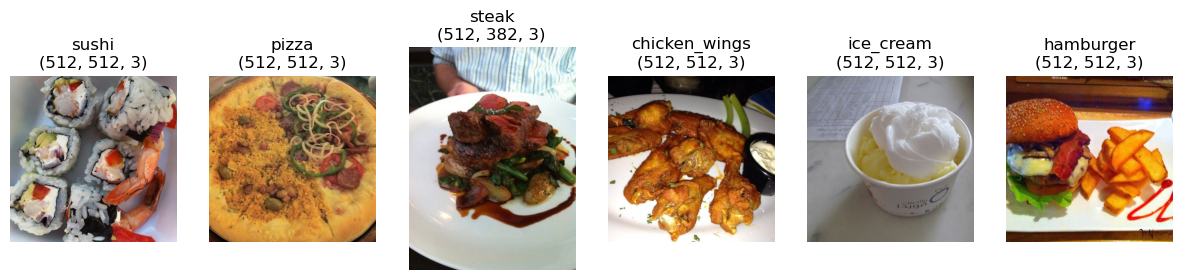

In [4]:
view_random_images(data_dir, 6)

## Experiment

### baseline

In [5]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
learning_rate = 1e-3
epochs = 5

#### Prepare datasets

In [6]:
train_dir = data_dir+'/train'
test_dir = data_dir+'/test'
train_data, val_data, test_data = create_datasets(
    train_dir,
    test_dir,
    IMAGE_SIZE,
    BATCH_SIZE
)

Found 750 files belonging to 10 classes.
Using 600 files for training.
Found 750 files belonging to 10 classes.
Using 150 files for validation.


2023-01-11 14:52:58.963205: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 2500 files belonging to 10 classes.


In [7]:
class_names = train_data.class_names
class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [14]:
# Xem ví dụ về batch của dữ liệu
for images, labels in train_data.take(1):
  print(images, labels)

tf.Tensor(
[[[[5.67704086e+01 4.07704086e+01 6.77040815e+00]
   [5.60714302e+01 4.10714302e+01 8.07142830e+00]
   [5.70000000e+01 4.20000000e+01 9.00000000e+00]
   ...
   [9.70000000e+01 1.13000000e+02 1.12000000e+02]
   [9.60714111e+01 1.12071411e+02 1.11071411e+02]
   [9.57704086e+01 1.11770409e+02 1.08770409e+02]]

  [[5.81938782e+01 4.04030609e+01 9.19387817e+00]
   [5.79336739e+01 4.10051003e+01 1.07908173e+01]
   [5.87857132e+01 4.18010178e+01 1.17551022e+01]
   ...
   [9.77857056e+01 1.13785706e+02 1.12785706e+02]
   [9.69336700e+01 1.12933670e+02 1.11933670e+02]
   [9.60000000e+01 1.12000000e+02 1.09000000e+02]]

  [[6.10000000e+01 4.00000000e+01 1.30000000e+01]
   [6.02857170e+01 4.00714302e+01 1.30714283e+01]
   [6.13826523e+01 4.17857132e+01 1.29336739e+01]
   ...
   [9.83367310e+01 1.14000000e+02 1.13168365e+02]
   [9.70714111e+01 1.13071411e+02 1.12071411e+02]
   [9.70000000e+01 1.13000000e+02 1.10000000e+02]]

  ...

  [[1.01214264e+02 9.02142639e+01 5.94999771e+01]
   [1

#### Build model

In [8]:

baseline = create_baseline(IMAGE_SIZE, len(class_names) , include_data_augmentation=False)

In [9]:
baseline.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 sequential (Sequential)     (None, 128)               6446240   
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 6,447,530
Trainable params: 6,447,530
Non-trainable params: 0
_________________________________________________________________


#### Train model

In [11]:
from tensorflow.keras.optimizers import Adam

baseline.compile(
    optimizer=Adam(learning_rate),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
baseline_history = baseline.fit(
    train_data,
    epochs=epochs,
    validation_data=val_data,
)

Epoch 1/5
19/19 [==============================] - 12s 588ms/step - loss: 2.6081 - accuracy: 0.1083 - val_loss: 2.2981 - val_accuracy: 0.0800
Epoch 2/5
19/19 [==============================] - 12s 607ms/step - loss: 2.2575 - accuracy: 0.1700 - val_loss: 2.2498 - val_accuracy: 0.1867
Epoch 3/5
19/19 [==============================] - 12s 610ms/step - loss: 2.0637 - accuracy: 0.2817 - val_loss: 2.1534 - val_accuracy: 0.2467
Epoch 4/5
19/19 [==============================] - 12s 647ms/step - loss: 1.7830 - accuracy: 0.3717 - val_loss: 2.2628 - val_accuracy: 0.2467
Epoch 5/5
19/19 [==============================] - 13s 679ms/step - loss: 1.4514 - accuracy: 0.5117 - val_loss: 2.3902 - val_accuracy: 0.2067


#### Evaluate model

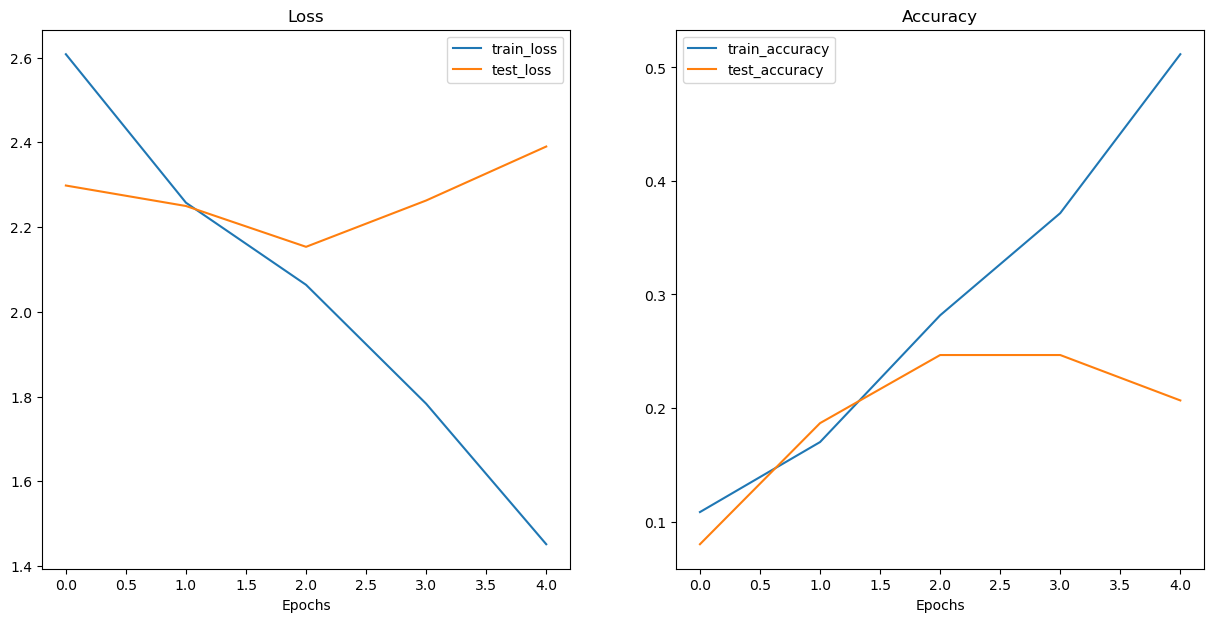

In [12]:
plot_loss_curves(baseline_history.history)

In [13]:
baseline.evaluate(test_data)

2500/2500 [==============================] - 21s 8ms/step - loss: 2.4438 - accuracy: 0.2156


[2.4437832832336426, 0.21559999883174896]

### efficientnet_b0 (feature extraction)

In [5]:
pretrained_model_name = 'efficientnet_b0'
IMAGE_SIZE = input_image_size(pretrained_model_name)
BATCH_SIZE = 32
learning_rate = 1e-3
epochs = 5

print("Image size:", IMAGE_SIZE)

Image size: (224, 224)


#### Prepare datasets

In [6]:
train_dir = data_dir+'/train'
test_dir = data_dir+'/test'
train_data, val_data, test_data = create_datasets(
    train_dir,
    test_dir,
    IMAGE_SIZE,
    BATCH_SIZE
)

Found 750 files belonging to 10 classes.
Using 600 files for training.
Found 750 files belonging to 10 classes.
Using 150 files for validation.


2023-01-11 16:36:39.504160: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 2500 files belonging to 10 classes.


In [7]:
class_names = train_data.class_names
class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

#### Build model

In [8]:
efficientnet_b0 = create_model(pretrained_model_name, len(class_names))

In [9]:
efficientnet_b0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              4049564   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


#### Train model

In [11]:
from tensorflow.keras.optimizers import Adam

efficientnet_b0.compile(
    optimizer=Adam(learning_rate),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
efficientnet_b0_history = efficientnet_b0.fit(
    train_data,
    epochs=epochs,
    validation_data=val_data,
)

Epoch 1/5
19/19 [==============================] - 30s 1s/step - loss: 1.9313 - accuracy: 0.3783 - val_loss: 1.5130 - val_accuracy: 0.6267
Epoch 2/5
19/19 [==============================] - 24s 1s/step - loss: 1.2028 - accuracy: 0.7333 - val_loss: 1.0975 - val_accuracy: 0.7067
Epoch 3/5
19/19 [==============================] - 24s 1s/step - loss: 0.8668 - accuracy: 0.8217 - val_loss: 0.9066 - val_accuracy: 0.7533
Epoch 4/5
19/19 [==============================] - 23s 1s/step - loss: 0.7085 - accuracy: 0.8433 - val_loss: 0.8056 - val_accuracy: 0.7800
Epoch 5/5
19/19 [==============================] - 23s 1s/step - loss: 0.6032 - accuracy: 0.8683 - val_loss: 0.7431 - val_accuracy: 0.8133


#### Evaluate model

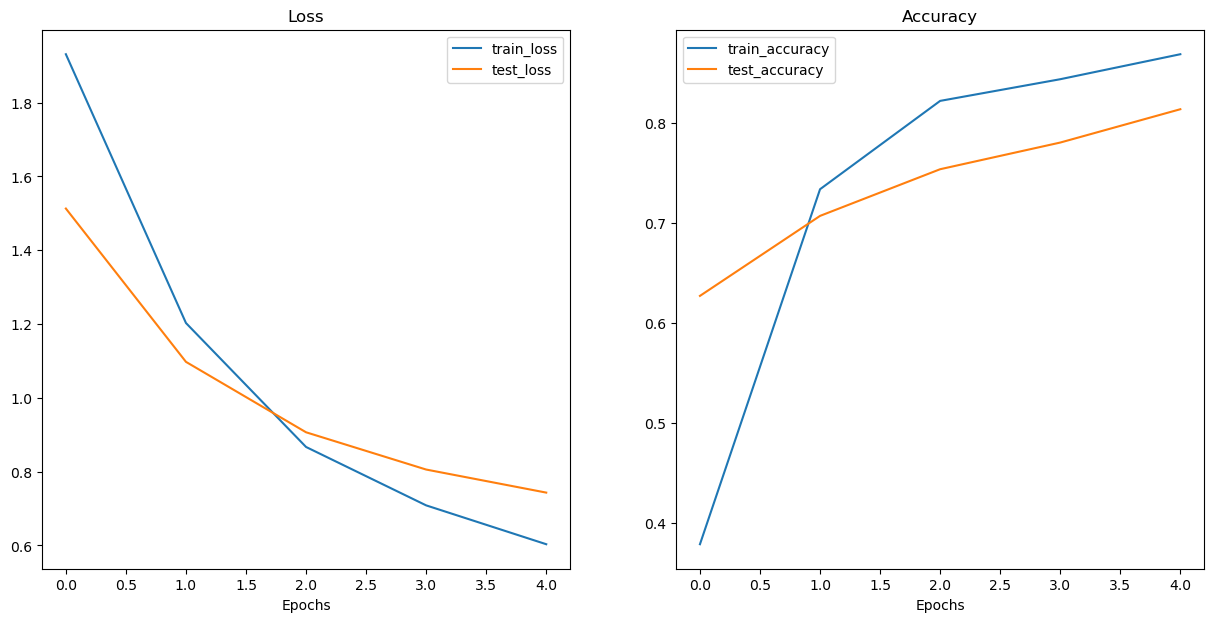

In [12]:
plot_loss_curves(efficientnet_b0_history.history)

In [13]:
efficientnet_b0.evaluate(val_data)

5/5 [==============================] - 4s 797ms/step - loss: 0.7431 - accuracy: 0.8133


[0.7431231141090393, 0.8133333325386047]

### efficientnet_b0 (fine-tuning)